In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from icevision.all import *

In [3]:
model_type = models.mmdet.fcos
# model_type = models.mmdet.retinanet
# model_type = models.mmdet.faster_rcnn

In [4]:
import icedata

In [5]:
data_dir = icedata.fridge.load_data()

In [6]:
parser = icedata.fridge.parser(data_dir)

In [7]:
train_records, valid_records = parser.parse()

INFO     - Autofixing records | icevision.parsers.parser:parse:135



In [8]:
presize, size = 256, 224
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(presize=presize, size=size), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

In [9]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [10]:
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

In [11]:
# cfg = "~/git/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py"
# weights_path = None

In [12]:
# cfg = "~/git/mmdetection/configs/retinanet/retinanet_r50_fpn_1x_coco.py"
# weights_path = "/home/lgvaz/git/mmdetection/checkpoints/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth"

In [13]:
# fcos
cfg = "/home/jeremy/Documents/code/oss/mmdetection/configs/fcos/fcos_r50_caffe_fpn_gn-head_4x4_1x_coco.py"
weights_path = None

In [14]:
model = model_type.model(cfg, num_classes=len(parser.class_map), weights_path=weights_path)

2021-03-13 07:53:32,493 - mmdet - INFO - load model from: open-mmlab://detectron/resnet50_caffe
2021-03-13 07:53:32,493 - mmdet - INFO - Use load_from_openmmlab loader
2021-03-13 07:53:32,569 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: conv1.bias, layer1.0.conv1.bias, layer1.0.conv2.bias, layer1.0.conv3.bias, layer1.0.downsample.0.bias, layer1.1.conv1.bias, layer1.1.conv2.bias, layer1.1.conv3.bias, layer1.2.conv1.bias, layer1.2.conv2.bias, layer1.2.conv3.bias, layer2.0.conv1.bias, layer2.0.conv2.bias, layer2.0.conv3.bias, layer2.0.downsample.0.bias, layer2.1.conv1.bias, layer2.1.conv2.bias, layer2.1.conv3.bias, layer2.2.conv1.bias, layer2.2.conv2.bias, layer2.2.conv3.bias, layer2.3.conv1.bias, layer2.3.conv2.bias, layer2.3.conv3.bias, layer3.0.conv1.bias, layer3.0.conv2.bias, layer3.0.conv3.bias, layer3.0.downsample.0.bias, layer3.1.conv1.bias, layer3.1.conv2.bias, layer3.1.conv3.bias, layer3.2.conv1.bias, layer3.2.conv

In [15]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, splitter=fastai.trainable_params)

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=4.365158383734524e-05)

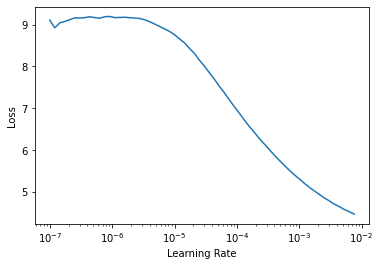

In [16]:
learn.lr_find()

In [17]:
learn.fine_tune(10, 3e-4)

In [18]:
learn.fine_tune(10, 3e-4)

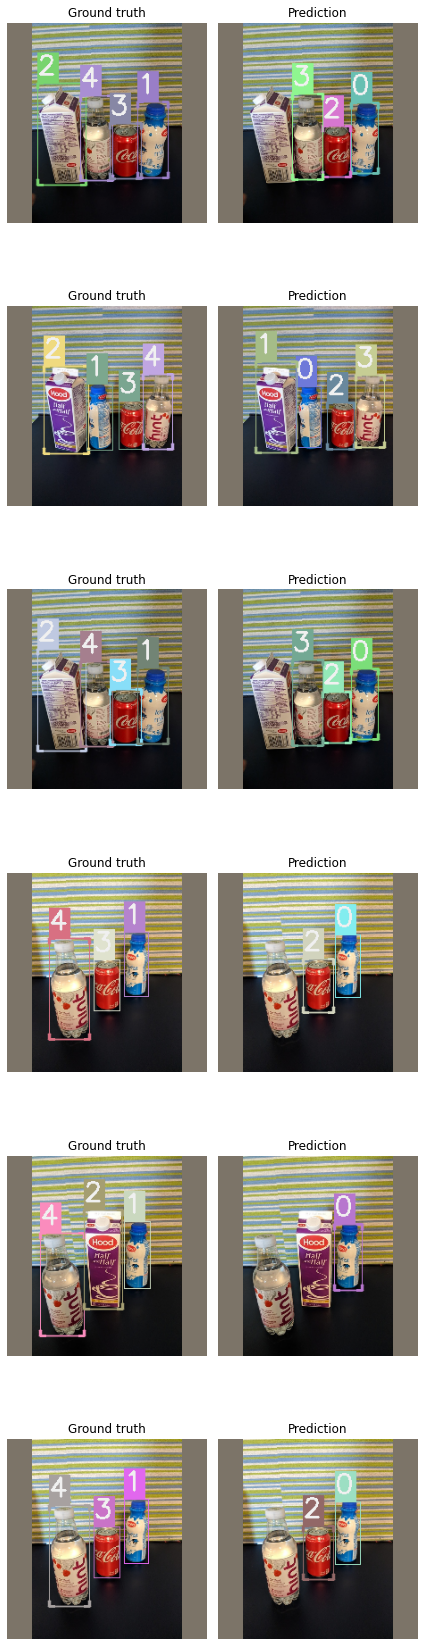

In [26]:
model_type.show_results(model, valid_ds)

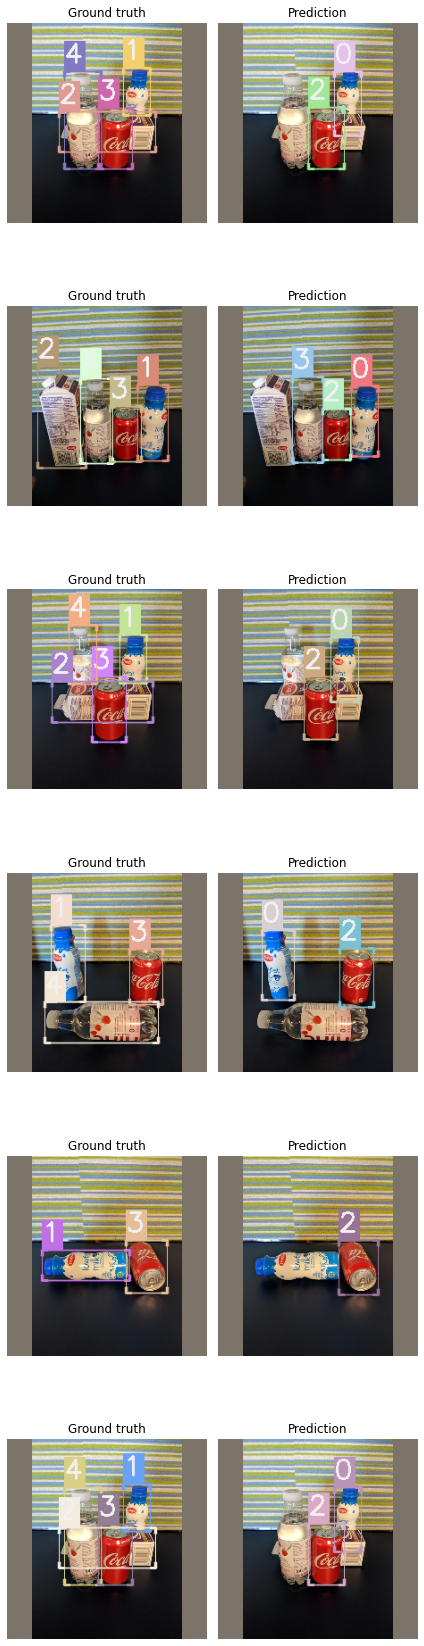

In [27]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

In [22]:
class LitModel(model_type.lightning.ModelAdapter):
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-4)
    
lit_model = LitModel(model)
trainer = pl.Trainer(max_epochs=10, gpus=1, num_sanity_val_steps=0, check_val_every_n_epoch=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [23]:
lr_finder = trainer.tuner.lr_find(lit_model, train_dl, valid_dl)


  | Name  | Type | Params
-------------------------------
0 | model | FCOS | 32 M  


<ipython-input-24-e87f252efa22>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



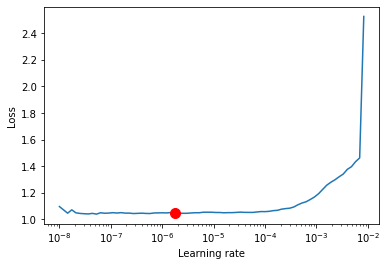

In [24]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [25]:
trainer.fit(lit_model, train_dl, valid_dl)


  | Name  | Type | Params
-------------------------------
0 | model | FCOS | 32 M  


1